# <u> 2012 - 2017 Crime in Chicago </u>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline
import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# <u>1. Dataset Description </u>
<ul>
    <li><b>df</b> is a dataset of all crimes from 2012 to 2017.
    <li>Each row reports an incident of crime that occurred in the city of Chicago.
    <li>We have 1,450,000 incidents from 2012 to 2017. However, only 11,357 incidents in 2017 so we drop these 2017 incidents.
    <li>Most common primary type of crime is <b>Theft</b>, following by <b>Battery, Criminal Damage </b>, then <b>Narcotics</b>.
</ul>
<b>Important columns in df are:</b>
<ol>
    <li><B>ID:</B> Unique crime identifier. We set this column as primary key.
    <li><B>Date:</B> Date when the incident occurred. This is sometimes a best estimate.
    <li><B>Primary Type:</B> Category of crime ( There are 33 unique categories).
    <li><B>Location Description:</B> Description of the location where the incident occurred.
    <li><B>Arrest:</B> True if criminal was arrested.
    <li><B>Domestic:</B> Indicates whether the incident was domestic-related.
    <li><B>Year:</B> Year the incident occurred.
    <li><B>Ward:</B> The ward (City Council district) where the incident occurred. (There are 50 unique wards).
    <li><B>Latitude:</B> Latitude of the location where the incident occurred.
    <li><B>Longitude:</B> Longitude of the location where the incident occurred.
</ol>

In [2]:
df = pd.read_csv('Chicago_Crimes_2012_to_2017.csv')
df.set_index('ID',inplace=True)

### Summary of dataset

In [3]:
df.head(1)

,Unnamed: 0,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
ID,,,,,,,,,,,,,,,,,,,,,
10508693,3,HZ250496,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,...,24.0,29.0,08B,1154907.0,1893681.0,2016,05/10/2016 03:56:50 PM,41.864073,-87.706819,"(41.864073157, -87.706818608)"


In [4]:
len(df)

1456714

Top Primary Type of Crime (number and percentage)

In [5]:
df['Primary Type'].value_counts().head(5)

THEFT              329460
BATTERY            263700
CRIMINAL DAMAGE    155455
NARCOTICS          135240
ASSAULT             91289
Name: Primary Type, dtype: int64

In [6]:
(df['Primary Type'].value_counts()/len(df)).head(5)

THEFT              0.226167
BATTERY            0.181024
CRIMINAL DAMAGE    0.106716
NARCOTICS          0.092839
ASSAULT            0.062668
Name: Primary Type, dtype: float64

# <u>2. Data Preparation </u>

#### Remove columns that unnecessary for the analysis

In [7]:
df2=df.copy()
df2.drop(columns=['Unnamed: 0','Case Number','Block','IUCR','FBI Code','Updated On','X Coordinate','Beat','District',\
                  'Community Area','Y Coordinate','Location'],inplace=True)

#### Remove incidents occured in 2017

In [8]:
df2 = df2[~(df2.Year == 2017)]

#### Remove null value for Latitude & Longitude as our analysis is based on these variables

In [9]:
df2=df2.loc[~df2['Latitude'].isnull()]

#### Converting  Arrest and Domestic  to  0/1 column

In [10]:
df2['Arrest']=(df.Arrest==True)*1
df2['Domestic']=(df.Domestic==True)*1

#### Adding the "month" column by extracting values from the 'Date' column for further analysis

In [11]:
df2['month']=df2.Date.astype(np.datetime64).dt.month

#### Find the "distance" from the ward which has the most crimes.

1. Find the ward with most crimes:

In [12]:
df2.groupby('Ward')['Arrest'].sum().nlargest(1)

Ward
28.0    31022
Name: Arrest, dtype: int64

2. Calculating the center point of the ward 28 where the most crimes occurred:

In [13]:
lat_mean=df2[df2.Ward==28].Latitude.mean()
long_mean=df2[df2.Ward==28].Longitude.mean()
location_mean=[lat_mean,long_mean]
location_mean

[41.88041595971569, -87.73128961681]

3. Calculate the distances in kilometres between ward 28 and other locations where incident of crime occurred, using <b>Haversine</b> package:

In [14]:
from haversine import *
def haversine_np(lon1, lat1):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, long_mean, lat_mean])

    distance_lon = lon2 - lon1
    distance_lat = lat2 - lat1

    a = np.sin(distance_lat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(distance_lon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

4. Creating column <b> "distance" </b> between ward 28 and other locations where the incident of crime occurred:

In [15]:
df2['distance']=df2.apply(lambda x: haversine_np(x.Longitude,x.Latitude),axis=1)

#### Create unsafe variable which is 1 for unsafe and 0 for safe ward

1. Calcuting the total crime per year and the total crime per year for each ward:

In [16]:
df2['crime_year']=df2.groupby('Year')['Arrest'].transform('size')
df2['crime_year_ward']=df2.groupby(['Ward','Year'])['Arrest'].transform('size')

2. Classifying ward as unsafe if its rate of incidents in a particular year is higher than the average rate of incidents in that year. 

In [17]:
df2['rate_ward_year']=df2.crime_year_ward/df2.crime_year
df2['mean_crime_year']=df2.groupby('Year')['rate_ward_year'].transform('mean')
df2['unsafe']=(df2.rate_ward_year>df2['mean_crime_year'])*1

#### Remove all columns that are not necessary anymore for the analysis

In [18]:
df2.drop(columns=['Latitude', 'Longitude', 'crime_year', 'crime_year_ward', 'rate_ward_year', 'mean_crime_year', \
                  'Date','Description','Location Description','Ward'], inplace=True)

#### Save a copy of dataset with Primary Type column for further analyis

In [19]:
df3 = df2.copy()

#### Get dummies for "Primary Type" column

In [20]:
df2= pd.get_dummies(df2,columns=['Primary Type'])

# <u>3. Interesting Finding Summary </u>

Narcotics are more likely to occur than theft in the most highly unsafe regions of Chicago (locations with distance less than 3 kilometers from the location with the most incidents of crimes, i.e ward 28). And theft is not the most common crime in these regions even though theft is the most prevalent in the dataset. 

<i>(In the dataset, theft contributed 22% while narcotics contributed only 9% among 33 different primary types of crime).</i> 

# <u>4. Machine Learning: Decision Tree </u>

###### After several attempts on using clustering, we did not see any popped-up patterns. We also tried to merge with other datasets such as weather or housing price in Chicago to see whether there are any relations. However, we did not see any interesting findings. So we tried to mine this dataset further. We found that decision tree gave us some interesting findings about distance.



In [21]:
x=df2.drop(columns='unsafe')
y=df2.unsafe
dt = tree.DecisionTreeClassifier(max_depth = 3)
dt.fit(x,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

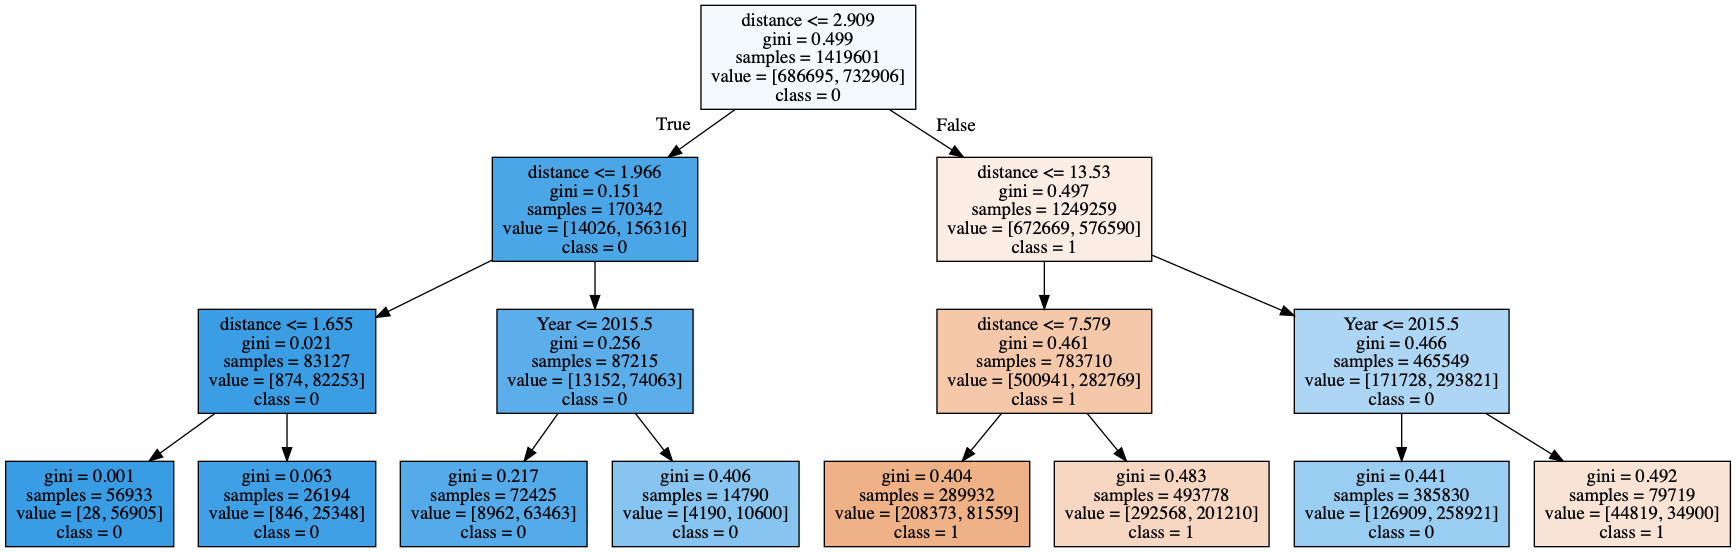

In [22]:
dt_feature_names = list(x.columns)
dt_target_names = np.array(y.unique(),dtype=np.str) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

#### Locations that are located less than 3 km away from ward 28 are more likely to be very unsafe. From this, we want to explore more about what the differences between the locations less than 3km and greater than 3km from the ward 28 (the ward with the most incidents of crime).

##### Create a dummy variable to identify whether location is within 3km from ward 28

In [23]:
df2['is_distance_3km']=(df2.distance<3)*1

##### Drop column "unsafe", "distance" as it is not necessary in our analysis anymore

In [24]:
df2.drop(columns = ['unsafe','distance'], inplace = True)

##### Creating Decision Tree with new dummy variable "is_distance_3km" as dependent variable


In [25]:
x=df2.drop(columns='is_distance_3km')
y=df2.is_distance_3km
dt = tree.DecisionTreeClassifier(max_depth = 3)
dt.fit(x,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

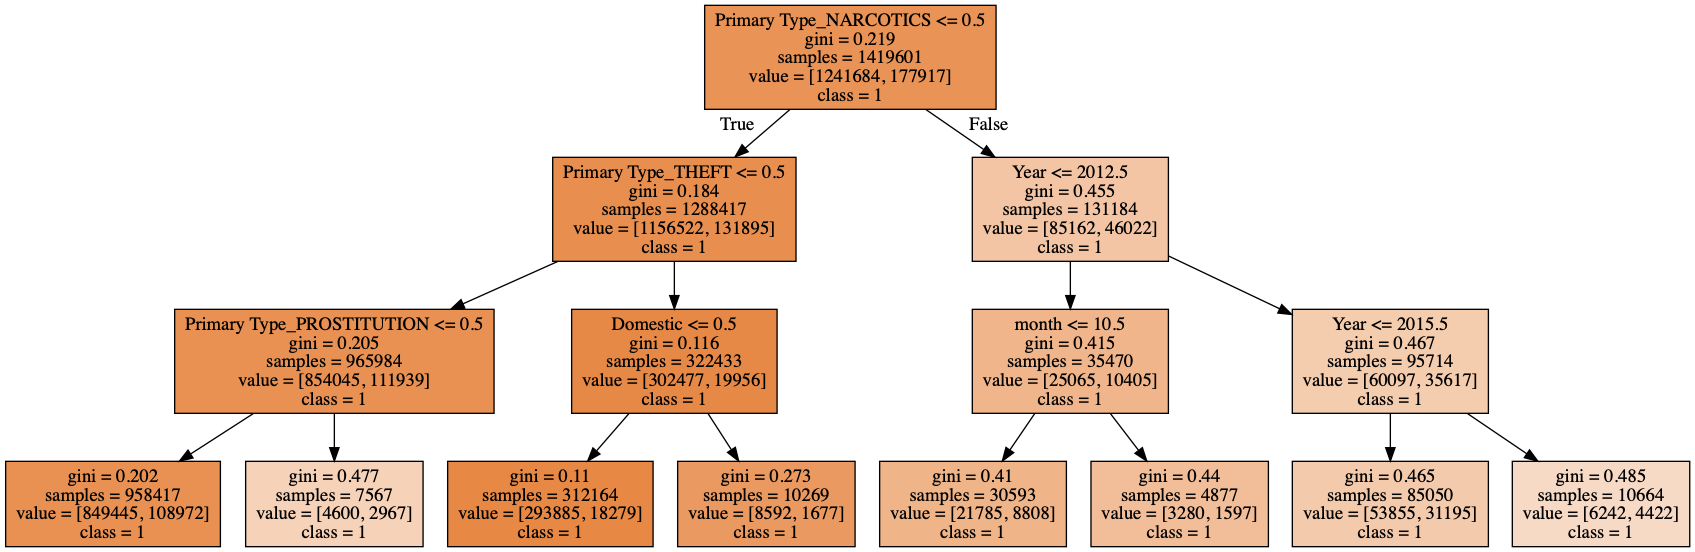

In [26]:
dt_feature_names = list(x.columns)
dt_target_names = np.array(y.unique(),dtype=np.str) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

The above tree tells us that:
1. Narcotics is a higher contributer of crime for the most highly unsafe regions (locations less than 3 km). Out of total crimes for the locations less than 3km (177,917 incidents), we see that 46,022 incidents of narcotics are present. Hence, narcotics is 25.9% of the total crimes for locations with distance less than 3km.
2. However, for the distance greater than 3km, narcotics is only 6.9% (=85,162/1,241,684) of all the crimes.
3. Similarly theft is only a 11.2% (=19,956/177,917) contributer of total crimes for the locations with distance less than 3km. But for the distance greater than 3km, it is a 24.4% (=302,477/1,241,684) contribtutor.

So narcotics is more likely to present in the locations with distance less than 3km as compared to theft, even though, overall in the whole data set, theft is the most common crime.

# <u>5. Validity of the Finding </u>

### Below are table/charts to validate our findings

#### Table to show the proportion of narcotics and theft for distance less than and greater than 3km 

In [27]:
v=df2.columns.tolist()
cols=[]
for l in v:
    if 'Primary' in l:
        cols.append(l)
df2.groupby(['is_distance_3km'])[cols].mean().T

is_distance_3km,0,1
Primary Type_ARSON,0.001535,0.001512
Primary Type_ASSAULT,0.063267,0.061568
Primary Type_BATTERY,0.179455,0.203005
Primary Type_BURGLARY,0.061109,0.032571
Primary Type_CONCEALED CARRY LICENSE VIOLATION,0.000056,0.000079
Primary Type_CRIM SEXUAL ASSAULT,0.004469,0.004210
Primary Type_CRIMINAL DAMAGE,0.111305,0.082123
Primary Type_CRIMINAL TRESPASS,0.026647,0.018801
Primary Type_DECEPTIVE PRACTICE,0.051275,0.026355
Primary Type_GAMBLING,0.001072,0.004946


### Chart to validate narcotics and theft over the year

Narcotics occured more often in locations with distance less than 3km from the location with the most incidents of crime while theft occured more often in locations with distance greater than 3km. 

/Users/michelle/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


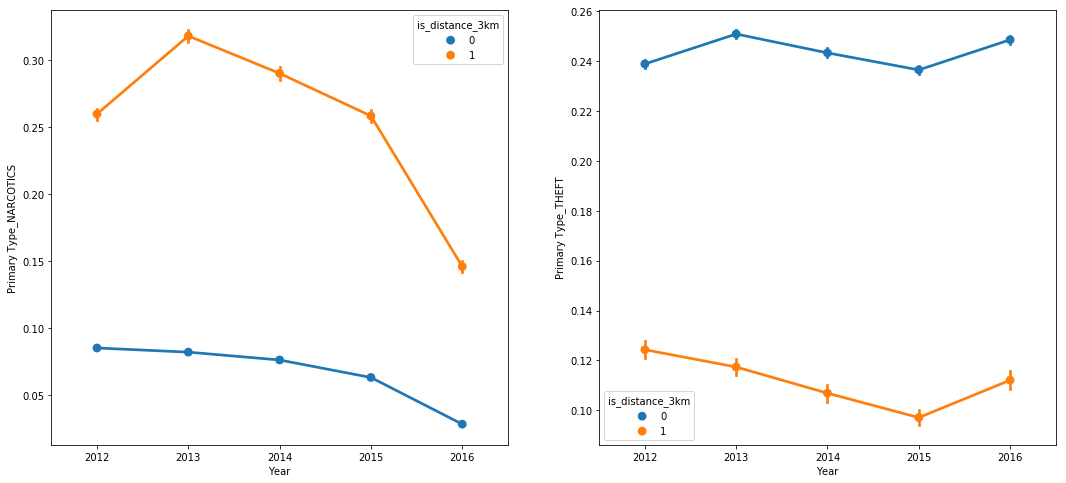

In [28]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(18, 8))
sns.catplot(data=df2,x='Year',y='Primary Type_NARCOTICS',kind ='point',aspect=1,hue='is_distance_3km',ax=ax1)
sns.catplot(data=df2,x='Year',y='Primary Type_THEFT',kind ='point',aspect=1,hue='is_distance_3km',ax=ax2)
plt.close(2)
plt.close(3)

### Chart to compare Theft & Narcotics over year.

Using the below graph, we can further validate that narcotics is more likely to occur than theft in locations with distance less 3km from the location with the most incidents of crime.

We use <b> df3 </b> dataset in which "Primary Type" is not dummy variable.

In [29]:
df3['is_distance_3km']=(df3.distance<3)*1

In [30]:
df3 = df3[(df3['Primary Type'] == 'THEFT') | (df3['Primary Type'] == 'NARCOTICS')]

/Users/michelle/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


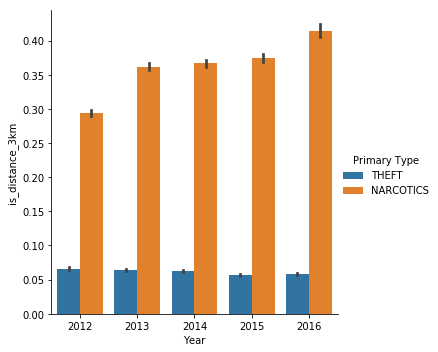

In [31]:
sns.factorplot(data=df3,x='Year',y='is_distance_3km',kind ='bar',aspect=1,hue='Primary Type')

# <u>6. Managerial Insights </u>

In conclusion, narcotics are more likely to occur than theft for the most highly unsafe regions in Chicago (locations with distance less than 3 kilometers from the location with the most incidents of crime, i.e ward 28). And theft is not the most common crime in these regions, even though theft is the most prevalent in the dataset.

This means that these regions are unsafe because of the higher concentration of crimes related to narcotics. This is a surprised finding, because overall, theft is the most prevalent crime with 22%, while narcotics is the 4th one with only 9%. At first, we had expected that the highest crime rate regions (locations with distance less than 3km) would have had higher rate of theft. However, it turns out that in these regions, crimes related to narcotics are even more frequent.

Hence, our suggestion is that for these unsafe regions, the police better watch out for narcotics crimes to prevent all actions and consequences related to narcotics. And police also better watch out for drug users in these regions becasue drug users are supposed to be more likely than nonusers to commit crimes. Handling these crimes may make these regions safer in the future, and overall not getting the bad reputation as being an unsafe region.
